# Player Skills
There are a few statistics I want to gather for each player wich will be very useful predictors. These are:
- p_ace: % ace per service point
- p_df: % double faults per service point
- p_1stIn: % first serves in
- p_1stWon: % points won on first serve
- p_2ndWon: % points won on second serve
- p_2ndWon_inPlay: % points won on second serve excluding df
- p_bpSaved: % breakpoints saved
- p_rpw: % return points won
- p_retAceAgainst: % opponent aces per serve point
- p_ret1stWon: % points won on opponent 1st serve
- p_ret2ndWon: % points won on opponent 2nd serve
- p_ret2ndWon_inPlay: % points won on opponent 2nd serve excluding opp df
- p_bpConv: % break points converted
- p_totalPtsWon: % total points won
- dominance_ratio: return % / serve lost %

These statistics that measure **skill** can be calculated using an EWMA. The EWMA will be calculated with a hybrid dt approach. 

dt will typically be fixed at 1, meaning each match is treated equally. 

However, if the days since the last update surpasses some threshold, the dt will increase to make sure we quickly readjust to the player's new skill level to reflect a break in activity

This approach has flaws, since the first match back will have a disproportionate effect on the overall statistic. This will be partially mitigated by capping dt at a certain value.

We first add the features that benefit from EWMA weighting. These will be features that changed based off a player's skill. 

Below is a general function that takes in a lambda expression for feature calculations.

In [1]:
import numpy as np
import pandas as pd

# read the cleaned dataframe
df = pd.read_parquet("../../data/cleaned/atp_matches_cleaned.parquet")
print(df.columns)

Index(['surface', 'draw_size', 'tourney_level', 'tourney_date', 'id_a',
       'name_a', 'hand_a', 'ht_a', 'age_a', 'id_b', 'name_b', 'hand_b', 'ht_b',
       'age_b', 'score', 'best_of', 'round', 'minutes', 'ace_a', 'df_a',
       'svpt_a', '1stIn_a', '1stWon_a', '2ndWon_a', 'SvGms_a', 'bpSaved_a',
       'bpFaced_a', 'ace_b', 'df_b', 'svpt_b', '1stIn_b', '1stWon_b',
       '2ndWon_b', 'SvGms_b', 'bpSaved_b', 'bpFaced_b', 'rank_a',
       'rank_points_a', 'rank_b', 'rank_points_b', 'result'],
      dtype='object')


In [2]:
from datetime import datetime
import math
from collections import defaultdict
import pandas as pd

def add_ewma_features(
    df: pd.DataFrame,
    feature_computers: dict,
    half_life: int = 25,
    break_gap: int = 20,
    max_dt: int = 3,
) -> pd.DataFrame:
    """
    Adds EWMA columns for multiple features to the dataframe.
    """
    if not feature_computers:
        raise ValueError("Must provide at least one feature computer.")
    
    lambda_ = math.log(2) / half_life

    # init output columns
    for feature in feature_computers:
        df[f"{feature}_a"] = 0.0
        df[f"{feature}_b"] = 0.0

    # player_id -> feature -> (value, last_date)
    recent = defaultdict(lambda: defaultdict(lambda: (0.0, datetime.min)))

    df = df.sort_values("tourney_date").reset_index(drop=True)

    for idx, row in df.iterrows():
        today_date = datetime.strptime(str(row["tourney_date"]), "%Y%m%d")

        for side in ["a", "b"]:
            player_id = row[f"id_{side}"]
            last_modified_date = None
            days = None

            for feature, compute_func in feature_computers.items():
                current_value, last_date = recent[player_id][feature]
                df.loc[idx, f"{feature}_{side}"] = current_value

                if last_modified_date is None:
                    last_modified_date = last_date
                    days = (today_date - last_modified_date).days
                    dt = min(max_dt, max(1.0, (days - break_gap) / 10.0))
                    decay = math.exp(-lambda_ * dt)

                game_value = compute_func(row, side)

                if last_date == datetime.min:
                    new_value = game_value
                else:
                    new_value = (1 - decay) * game_value + decay * current_value

                recent[player_id][feature] = (new_value, today_date)

    return df


The above code adds a EMWA adjusted % ace / service point. Higher half life means older results decay slower.

We can now describe how to calculate certain features using lambda functions.

In [3]:
def _opp(side):
    return "b" if side == "a" else "a"

feature_computers = {
    # Serve performance
    "p_ace": lambda row, side: getattr(row, f"ace_{side}") / (getattr(row, f"svpt_{side}") + 1e-4),
    
    "p_df": lambda row, side: getattr(row, f"df_{side}") / (getattr(row, f"svpt_{side}") + 1e-4),

    # Conditional win percentages
    "p_1stIn": lambda row, side: getattr(row, f"1stIn_{side}") / (getattr(row, f"svpt_{side}") + 1e-4),

    "p_1stWon": lambda row, side: getattr(row, f"1stWon_{side}") / (getattr(row, f"1stIn_{side}") + 1e-4),

    "p_2ndWon": lambda row, side: getattr(row, f"2ndWon_{side}") / 
        ((getattr(row, f"svpt_{side}") - getattr(row, f"1stIn_{side}")) + 1e-4
    ),

    "p_2ndWon_inPlay": lambda row, side: (
        row[f"2ndWon_{side}"]
        / (row[f"svpt_{side}"] - row[f"1stIn_{side}"] - row[f"df_{side}"] + 1e-4)
    ),

    # Break point defense
    "p_bpSaved": lambda row, side: getattr(row, f"bpSaved_{side}") / (getattr(row, f"bpFaced_{side}") + 1e-4),

    # Return performance
    "p_rpw": lambda row, side: (
        getattr(row, f"svpt_{_opp(side)}") 
        - getattr(row, f"1stWon_{_opp(side)}") 
        - getattr(row, f"2ndWon_{_opp(side)}")
    ) / (getattr(row, f"svpt_{_opp(side)}") + 1e-4),

    # Return: opponent aces per serve point
    "p_retAceAgainst": lambda row, side: getattr(row, f"ace_{_opp(side)}") / (getattr(row, f"svpt_{_opp(side)}") + 1e-4),

    # Return: points won on opponent 1st serve
    "p_ret1stWon": lambda row, side: (
        getattr(row, f"1stIn_{_opp(side)}") - getattr(row, f"1stWon_{_opp(side)}")
    ) / (getattr(row, f"1stIn_{_opp(side)}") + 1e-4),

    # Return: points won on opponent 2nd serve
    "p_ret2ndWon": lambda row, side: (
        row[f"svpt_{_opp(side)}"]
        - row[f"1stIn_{_opp(side)}"]
        - row[f"2ndWon_{_opp(side)}"]
    ) / (row[f"svpt_{_opp(side)}"] - row[f"1stIn_{_opp(side)}"] + 1e-4),

    # Return: points won on opponent 2nd serve excluding opp df
    "p_ret2ndWon_inPlay": lambda row, side: (
        (row[f"svpt_{_opp(side)}"] 
        - row[f"1stIn_{_opp(side)}"] 
        - row[f"df_{_opp(side)}"]) 
        - row[f"2ndWon_{_opp(side)}"]
    ) / (
        (row[f"svpt_{_opp(side)}"] 
        - row[f"1stIn_{_opp(side)}"] 
        - row[f"df_{_opp(side)}"]) + 1e-4
    ),

    # Break point conversion
    "p_bpConv": lambda row, side: (
        getattr(row, f"bpFaced_{_opp(side)}") - getattr(row, f"bpSaved_{_opp(side)}")
    ) / (getattr(row, f"bpFaced_{_opp(side)}") + 1e-4),

    # Total points won
    "p_totalPtsWon": lambda row, side: (
        row[f"1stWon_{side}"] 
        + row[f"2ndWon_{side}"]
        + (
            row[f"svpt_{_opp(side)}"]
            - row[f"1stWon_{_opp(side)}"]
            - row[f"2ndWon_{_opp(side)}"]
        )
    ) / (row[f"svpt_{side}"] + row[f"svpt_{_opp(side)}"] + 1e-4),


    # Dominance ratio: return% / serve lost%, capped at 3 for when serve lost% = 0
    "dominance_ratio": lambda row, side: min(3, 
    (
        (
            getattr(row, f"svpt_{_opp(side)}")
            - getattr(row, f"1stWon_{_opp(side)}")
            - getattr(row, f"2ndWon_{_opp(side)}")
        ) / (getattr(row, f"svpt_{_opp(side)}") + 1e-4)
    ) / (
        1 - (
            getattr(row, f"1stWon_{side}") + getattr(row, f"2ndWon_{side}")
        ) / (getattr(row, f"svpt_{side}") + 1e-4)
    )),
}


# run the method and update df
df = add_ewma_features(df, feature_computers)

# save the df to csv
df.to_csv("./data/skill_features.csv", index=False)

In [4]:
df

,surface,draw_size,tourney_level,tourney_date,id_a,name_a,hand_a,ht_a,age_a,id_b,...,p_ret2ndWon_a,p_ret2ndWon_b,p_ret2ndWon_inPlay_a,p_ret2ndWon_inPlay_b,p_bpConv_a,p_bpConv_b,p_totalPtsWon_a,p_totalPtsWon_b,dominance_ratio_a,dominance_ratio_b
0,Hard,32,A,19910107,101142,Emilio Sanchez,R,180.0,25.6,101746,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Hard,32,A,19910107,100923,Wally Masur,R,180.0,27.6,100656,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Hard,32,A,19910107,100587,Steve Guy,R,188.0,31.8,101613,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Hard,32,A,19910107,101601,Brett Steven,R,185.0,21.6,101179,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Hard,32,A,19910107,101332,Gilad Bloom,L,173.0,23.8,101117,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91314,Hard,8,F,20241218,210460,Nishesh Basavareddy,R,180.0,19.6,210506,...,0.526313,0.485978,0.470585,0.424976,0.166664,0.344829,0.457746,0.496644,0.738634,1.047030
91315,Hard,8,F,20241218,209414,Luca Van Assche,R,178.0,20.5,209992,...,0.500518,0.506410,0.454690,0.456595,0.366015,0.318151,0.507658,0.499119,1.176103,1.077238
91316,Hard,8,F,20241218,210150,Jakub Mensik,R,193.0,19.2,210530,...,0.485159,0.450014,0.433773,0.436936,0.390033,0.306778,0.491960,0.452389,1.021318,0.767712
91317,Hard,8,F,20241218,209950,Arthur Fils,R,185.0,20.5,210150,...,0.477992,0.483856,0.423997,0.432850,0.294837,0.406710,0.489073,0.491251,1.019431,1.012839


### Graphing & Utility
To visualise data, we can create a method to graph a feature over matches or time.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

def get_player_id(df: pd.DataFrame, player_name: str) -> int:
    """
    Retrieves the unique player ID for a given player name from the DataFrame.
    
    Assumptions:
    - The DataFrame has columns 'name_a', 'id_a', 'name_b', 'id_b'.
    - Player names are consistent and map to a single unique ID.
    - Raises ValueError if no ID found or multiple IDs detected (for accuracy).
    
    Args:
        df: The tennis matches DataFrame.
        player_name: The full name of the player (e.g., "Roger Federer").
    
    Returns:
        The integer player ID.
    
    Example:
        player_id = get_player_id(df, "Roger Federer")
    """
    # Extract IDs from name_a and name_b columns
    a_ids = df.loc[df['name_a'] == player_name, 'id_a'].unique()
    b_ids = df.loc[df['name_b'] == player_name, 'id_b'].unique()
    
    # Combine and deduplicate
    all_ids = set(a_ids).union(set(b_ids))
    
    if len(all_ids) == 0:
        raise ValueError(f"No matches found for player '{player_name}' in the DataFrame.")
    elif len(all_ids) > 1:
        raise ValueError(f"Multiple IDs found for '{player_name}': {all_ids}. Data inconsistency detected.")
    
    return list(all_ids)[0]

def plot_player_stat(df: pd.DataFrame, player_id: int, stat: str, x_axis: str = "matches") -> None:
    """
    Plots the specified stat for a player over matches or time.
    
    Assumptions:
    - The DataFrame has columns 'id_a', 'id_b', 'tourney_date', and stat columns like 'p_ace_a', 'p_ace_b'.
    - 'tourney_date' is in YYYYMMDD integer format.
    - Player appears as either player A or B in matches.
    - Stat is precomputed (e.g., via EWMA) and symmetric (e.g., 'p_ace_a' for A, 'p_ace_b' for B).
    - Uses Matplotlib for plotting; call in Jupyter to display inline.
    
    Args:
        df: The tennis matches DataFrame.
        player_id: The player's ID (from get_player_id).
        stat: The stat column prefix (e.g., "p_ace").
        x_axis: "matches" for cumulative match number, or "time" for dates.
    
    Returns:
        None (displays plot via plt.show()).
    
    Example:
        plot_player_stat(df, player_id, "p_ace", x_axis="matches")
    """
    # Identify matches where player is A or B
    is_a = df['id_a'] == player_id
    is_b = df['id_b'] == player_id
    
    player_matches = df[is_a | is_b].copy()
    
    if player_matches.empty:
        raise ValueError(f"No matches found for player ID {player_id}.")
    
    # Extract the player's stat value (A or B side)
    player_matches['player_stat'] = np.where(is_a[player_matches.index], player_matches[f"{stat}_a"], player_matches[f"{stat}_b"])
    
    # Sort by tourney_date for chronological order
    player_matches = player_matches.sort_values('tourney_date').reset_index(drop=True)
    
    # Determine x-axis
    if x_axis == "matches":
        x = range(1, len(player_matches) + 1)
        xlabel = "Match Number (Chronological)"
    elif x_axis == "time":
        x = player_matches['tourney_date'].apply(lambda d: datetime.strptime(str(d), "%Y%m%d"))
        xlabel = "Tournament Date"
    else:
        raise ValueError(f"Invalid x_axis: '{x_axis}'. Must be 'matches' or 'time'.")
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, player_matches['player_stat'], linestyle='-')
    plt.xlabel(xlabel)
    plt.ylabel(stat.upper())
    plt.title(f"{stat.upper()} Over {x_axis.capitalize()} for Player ID {player_id}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

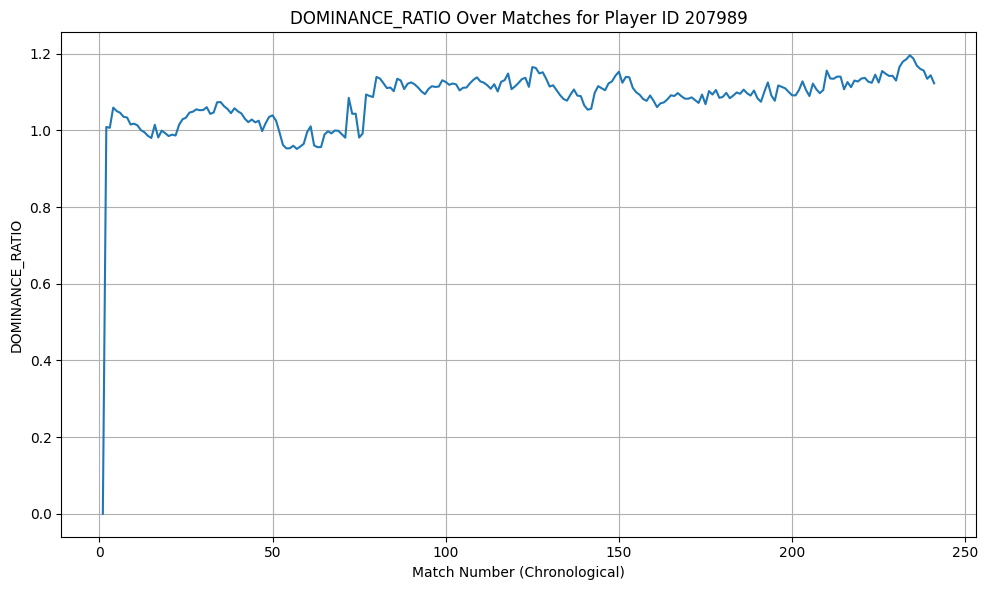

In [6]:
plot_player_stat(df, get_player_id(df, "Carlos Alcaraz"), "dominance_ratio", x_axis="matches")